In [1]:
import os
from copy import copy

import matplotlib.pyplot as plt
import numpy as np
from Basilisk import __path__

bskPath = __path__[0]
fileName = os.path.basename(os.path.splitext(os.path.abspath(''))[0])

from Basilisk.simulation import spacecraft
from Basilisk.utilities import macros
from Basilisk.utilities import orbitalMotion
from Basilisk.utilities import simIncludeGravBody
from Basilisk.utilities import SimulationBaseClass
from Basilisk.utilities import unitTestSupport
from Basilisk.utilities import vizSupport

In [2]:
def plotOrbits(timeAxis, posData, velData, oe, mu, P, orbitCase, planetCase, planet):
    # draw the inertial position vector components
    plt.close("all")  # clears out plots from earlier test runs
    plt.figure(1)
    fig = plt.gcf()
    ax = fig.gca()
    ax.ticklabel_format(useOffset=False, style='plain')
    finalDiff = 0.0

    for idx in range(3):
        plt.plot(timeAxis * macros.NANO2SEC / P, posData[:, idx] / 1000.,
                 color=unitTestSupport.getLineColor(idx, 3),
                 label='$r_{BN,' + str(idx) + '}$')
    plt.legend(loc='lower right')
    plt.xlabel('Time [orbits]')
    plt.ylabel('Inertial Position [km]')
    figureList = {}
    pltName = fileName + "1" + orbitCase + planetCase
    figureList[pltName] = plt.figure(1)

    # draw orbit in perifocal frame
    b = oe.a * np.sqrt(1 - oe.e * oe.e)
    p = oe.a * (1 - oe.e * oe.e)
    plt.figure(2, figsize=np.array((1.0, b / oe.a)) * 4.75, dpi=100)
    plt.axis(np.array([-oe.rApoap, oe.rPeriap, -b, b]) / 1000 * 1.25)
    # draw the planet
    fig = plt.gcf()
    ax = fig.gca()
    if planetCase == 'Mars':
        planetColor = '#884400'
    else:
        planetColor = '#008800'
    planetRadius = planet.radEquator / 1000
    ax.add_artist(plt.Circle((0, 0), planetRadius, color=planetColor))
    # draw the actual orbit
    rData = []
    fData = []
    for idx in range(0, len(posData)):
        oeData = orbitalMotion.rv2elem(mu, posData[idx], velData[idx])
        rData.append(oeData.rmag)
        fData.append(oeData.f + oeData.omega - oe.omega)
    plt.plot(rData * np.cos(fData) / 1000, rData * np.sin(fData) / 1000, color='#aa0000', linewidth=3.0
             )
    # draw the full osculating orbit from the initial conditions
    fData = np.linspace(0, 2 * np.pi, 100)
    rData = []
    for idx in range(0, len(fData)):
        rData.append(p / (1 + oe.e * np.cos(fData[idx])))
    plt.plot(rData * np.cos(fData) / 1000, rData * np.sin(fData) / 1000, '--', color='#555555'
             )
    plt.xlabel('$i_e$ Cord. [km]')
    plt.ylabel('$i_p$ Cord. [km]')
    plt.grid()

    plt.figure(3)
    fig = plt.gcf()
    ax = fig.gca()
    ax.ticklabel_format(useOffset=False, style='plain')
    Deltar = np.empty((0, 3))
    E0 = orbitalMotion.f2E(oe.f, oe.e)
    M0 = orbitalMotion.E2M(E0, oe.e)
    n = np.sqrt(mu/(oe.a*oe.a*oe.a))
    oe2 = copy(oe)
    for idx in range(0, len(posData)):
        M = M0 + n * timeAxis[idx] * macros.NANO2SEC
        Et = orbitalMotion.M2E(M, oe.e)
        oe2.f = orbitalMotion.E2f(Et, oe.e)
        rv, vv = orbitalMotion.elem2rv(mu, oe2)
        Deltar = np.append(Deltar, [posData[idx] - rv], axis=0)
    for idx in range(3):
        plt.plot(timeAxis * macros.NANO2SEC / P, Deltar[:, idx] ,
                 color=unitTestSupport.getLineColor(idx, 3),
                 label=r'$\Delta r_{BN,' + str(idx) + '}$')
    plt.legend(loc='lower right')
    plt.xlabel('Time [orbits]')
    plt.ylabel('Trajectory Differences [m]')
    pltName = fileName + "3" + orbitCase + planetCase
    figureList[pltName] = plt.figure(3)

    finalDiff = np.linalg.norm(Deltar[-1])

    pltName = fileName + "2" + orbitCase + planetCase
    figureList[pltName] = plt.figure(2)
    
    return figureList, finalDiff

In [3]:
# 'LEO'   Low Earth Orbit
# 'GEO'   Geosynchronous Orbit
# 'GTO'   Geostationary Transfer Orbit
orbit_case = 'LEO' # (LEO, GTO, GEO) 
planet_case = 'Earth' # (Earth, Mars)

# Create an empty simulation

In [4]:
simulation = SimulationBaseClass.SimBaseClass()

# Create a process

In [5]:
process_name = "simProcess"
process = simulation.CreateNewProcess(process_name)

# Create a task and specify the update rate

In [6]:
task_name = "simTask"
task_rate = macros.sec2nano(10.)
process.addTask(simulation.CreateNewTask(task_name, task_rate))

# Create and configure spacecraft module

In [7]:
# The dynamics simulation is setup using a Spacecraft() module.
spacecraft = spacecraft.Spacecraft()
spacecraft.ModelTag = "bsk-Sat"

# add spacecraft object to the simulation process
simulation.AddModelToTask(task_name, spacecraft)

# Create and configure gravity body module

In [8]:
# The first step to adding gravity objects is to create the gravity body factor class.  Note that
# this call will create an empty gravitational body list each time this script is called.  Thus, there
# is not need to clear any prior list of gravitational bodies.
gravity_factory = simIncludeGravBody.gravBodyFactory()

# To attach an Earth or Mars gravity model to this spacecraft, the following macros  invoked.
# The gravFactor() class stores the Earth gravitational object within the class, but it also returns a
# handler to this gravitational object as a convenience.  The celestial object position and velocity
# vectors are all defaulted to zero values.  If non-zero values are required, this can be manually
# overridden.  If multiple bodies are simulated, then their positions can be
# dynamically updated.  See scenarioOrbitMultiBody.py to learn how this is
# done via a SPICE object.
if planet_case == 'Mars':
    planet = gravity_factory.createMarsBarycenter()
    planet.isCentralBody = True           # ensure this is the central gravitational body

else:  # Earth
    planet = gravity_factory.createEarth()
    planet.isCentralBody = True          # ensure this is the central gravitational body

mu = planet.mu

# Finally, the gravitational body must be connected to the spacecraft object.  This is done with
gravity_factory.addBodiesTo(spacecraft)
# Here the complete list of gravitational bodies is automatically assigned to the spacecraft, regardless if
# it is only one body like Earth or Mars, or a list of multiple bodies.

# Note that the default planets position and velocity vectors in the gravitational body are set to zero.  If
# alternate position or velocity vectors are required, this can be done by creating the planet ephemeris message
# that is connected to the gravity effector input message `planetBodyInMsg`.
# If time varying planet ephemeris messages are to be included use the Spice module.  For non-zero messages
# the planet's default ephemeris would be replaced with the desired custom values.

# Compute and set spacecraft initial conditions

In [9]:
# setup the orbit using classical orbit elements
oe = orbitalMotion.ClassicElements()
rLEO = 7000. * 1000      # meters
rGEO = 42000. * 1000     # meters
if orbit_case == 'GEO':
    oe.a = rGEO
    oe.e = 0.00001
    oe.i = 0.0 * macros.D2R
elif orbit_case == 'GTO':
    oe.a = (rLEO + rGEO) / 2.0
    oe.e = 1.0 - rLEO / oe.a
    oe.i = 0.0 * macros.D2R
else:
    oe.a = rLEO
    oe.e = 0.0001
    oe.i = 33.3 * macros.D2R
oe.Omega = 48.2 * macros.D2R
oe.omega = 347.8 * macros.D2R
oe.f = 85.3 * macros.D2R
rN, vN = orbitalMotion.elem2rv(mu, oe)
oe = orbitalMotion.rv2elem(mu, rN, vN)
# with circular or equatorial orbit, some angles are arbitrary

# To set the spacecraft initial conditions, the following initial position and velocity variables are set:
spacecraft.hub.r_CN_NInit = rN  # m   - r_BN_N
spacecraft.hub.v_CN_NInit = vN  # m/s - v_BN_N

# These vectors specify the inertial position and velocity vectors relative to the planet of the
# spacecraft center of mass location.  Note that there are 2 points that can be tracked.  The user always
# specifies the spacecraft center of mass location with the above code.  If the simulation output should be
# about another body fixed point B, this can be done as well.  This is useful in particular with more challenging
# dynamics where the center of mass moves relative to the body.  The following vector would specify the location of
# the spacecraft hub center of mass (Bc) relative to this body fixed point, as in
#
#    scObject.hub.r_BcB_B = [[0.0], [0.0], [1.0]]
#

# If this vector is not specified, as in this tutorial scenario, then it defaults to zero.  If only a rigid hub
# is modeled, the Bc (hub center of mass) is the same as C (spacecraft center of mass).  If the spacecraft contains
# state effectors such as hinged panels, fuel slosh, imbalanced reaction wheels, etc., then the points
# Bc and C would not be the same.  Thus, in this simple simulation the body fixed point B and
# spacecraft center of mass are identical.

# Compute the simulation duration

In [10]:
n = np.sqrt(mu / oe.a / oe.a / oe.a)
P = 2. * np.pi / n
simulation_duration = macros.sec2nano(0.75 * P)

# Record messages

In [11]:
# The msg recorder can be told to sample at an with a minimum hold period in nano-seconds.
# If no argument is provided, i.e. msg.recorder(), then a default 0ns minimum time period is used
# which causes the msg to be recorded on every task update rate.
# The recorder can be put onto a separate task with its own update rate.  However, this can be
# trickier to do as the recording timing must be carefully balanced with the module msg writing
# to avoid recording an older message.
num_data_points = 100
sampling_time = unitTestSupport.samplingTime(simulation_duration, task_rate, num_data_points)
# create a logging task object of the spacecraft output message at the desired down sampling ratio
spacecraft_state_msg_recorder = spacecraft.scStateOutMsg.recorder(sampling_time)
simulation.AddModelToTask(task_name, spacecraft_state_msg_recorder)

# Initialize and run simulation

In [12]:
# This function runs the self_init() and reset() routines on each module.
simulation.InitializeSimulation()
simulation.ConfigureStopTime(simulation_duration)
simulation.ExecuteSimulation()

# Retrieve the logged data

In [13]:
# the data is stored inside dataLog variable.  The time axis is stored separately from the data vector and
# can be access through dataLog.times().  The message data is access directly through the message
# variable names.
position_data = spacecraft_state_msg_recorder.r_BN_N
velocity_data = spacecraft_state_msg_recorder.v_BN_N

# Plot results

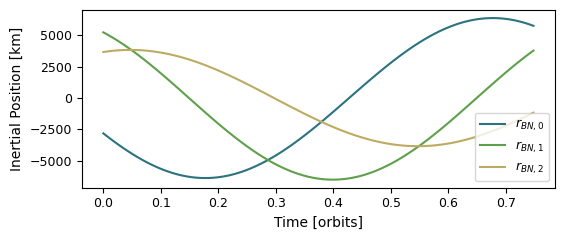

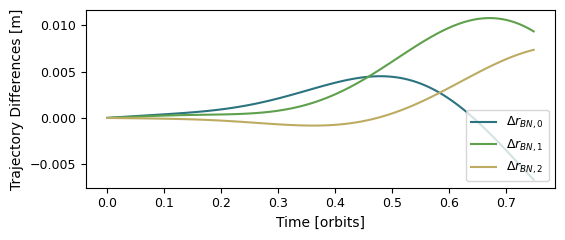

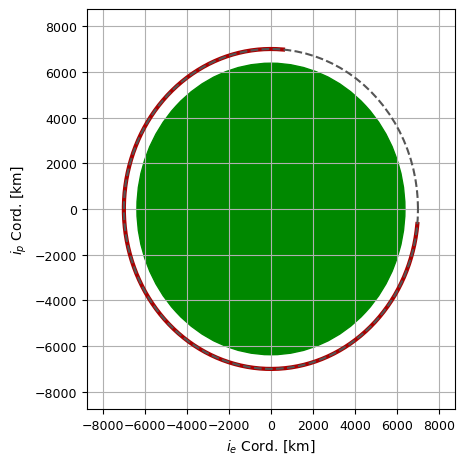

In [14]:
np.set_printoptions(precision=16)

# When the simulation completes 2 plots are shown for each case.  One plot always shows
# the inertial position vector components, while the second plot either shows a planar
# orbit view relative to the peri-focal frame, or the semi-major axis time history plot.
figureList, finalDiff = plotOrbits(spacecraft_state_msg_recorder.times(), 
                                   position_data, 
                                   velocity_data, 
                                   oe, 
                                   mu, 
                                   P,
                                   orbit_case,
                                   planet_case,
                                   planet)

plt.show()